In [54]:
!pip install neptune

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
import neptune
from neptune.utils import stringify_unsupported
from getpass import getpass

In [56]:
# Prompted to enter API token

api_token = getpass("Enter your private Neptune API token:")

Enter your private Neptune API token:··········


In [57]:
# Setting up a workspace in Neptune AI 

workspace = "somyagoel"
project_name = "520-final-project"
project = f"{workspace}/{project_name}"
print("Final Path:", project)

Final Path: somyagoel/520-final-project


In [58]:
# Initialising a run that will store all the model information in Neptune AI

run = neptune.init_run(
    project=project,
    api_token=api_token,
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
) 

https://app.neptune.ai/somyagoel/520-final-project/e/FIN-5


In [59]:
import torch
import torch.optim as optim
import torch.utils.data as data
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import _LRScheduler

from sklearn import decomposition
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

import copy
import random
import time

In [60]:
# seed information

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [61]:
ROOT = '.data'
# Loading the CIFAR 10 dataset 

train_data = datasets.CIFAR10(root=ROOT,
                              train=True,
                              download=True)

means = train_data.data.mean(axis=(0, 1, 2)) / 255
stds = train_data.data.std(axis=(0, 1, 2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Files already downloaded and verified
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


In [62]:
# Data preprocessing

train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])


In [63]:
# Loading training and Testing data

train_data = datasets.CIFAR10(ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [64]:
# Splitting 50,000 images into 45,000 training images and 5,000 validation images

VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [65]:
dataset_size = {"train": len(train_data), "val": len(valid_data)}

In [66]:
dataset_size

{'train': 45000, 'val': 5000}

**Logging dataset information**

In [67]:
# Logging dataset infromation in Neptune 

run["config/dataset/size"] = dataset_size

In [68]:
run["config/dataset/name"] = "CIFAR10"

In [69]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [70]:
# Normalizing the inputs

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [71]:
def plot_filter(images, filter, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
    filter = filter.repeat(3, 3, 1, 1)

    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    images = images.permute(0, 2, 3, 1)
    filtered_images = filtered_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize=(25, 5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title('Filtered')
        ax.axis('off')

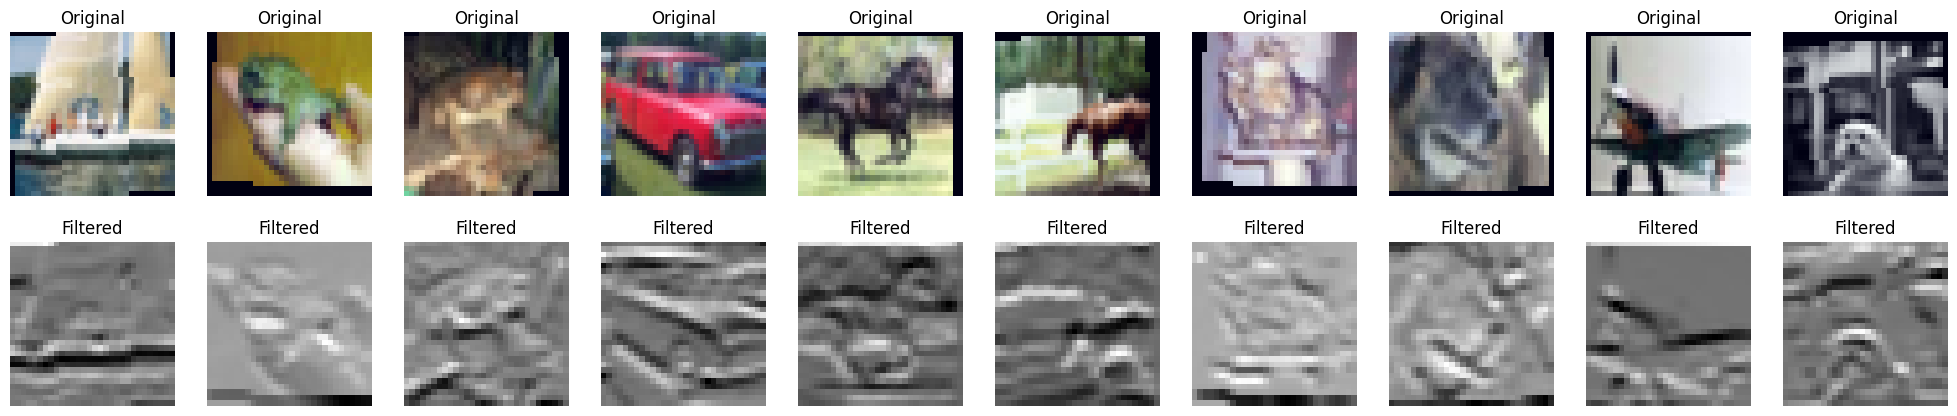

In [72]:
# Plotting 10 images after normalising them

N_IMAGES = 10

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

In [73]:
# Setting the batch size

BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

**Defining the model**

In [75]:
# Defining the model architecture (Reference : https://pytorch.org/hub/pytorch_vision_alexnet/)

class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [76]:
# Output classes are set to 10 as per the dataset labels

OUTPUT_DIM = 10

model = AlexNet(OUTPUT_DIM)

In [77]:
# This displays the model architecture

model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

**Logging the Hyperparameters**

In [78]:
# Logging all the hyperparameters being used to train the model

parameters = {
    "lr": 1e-3,
    "bs": 256,
    "epochs":25,
    "input_sz": 32 * 64 * 3,
    "n_classes": 10,
    "model_filename": "AlexNet",
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

run["config/hyperparameters"] = stringify_unsupported(parameters)

**Training the model**

In [33]:
# Using the Kaimimg initialisation to initilaise parameters (Reference : https://pytorch.org/docs/stable/nn.init.html)

def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [79]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [80]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss() # setting loss function as Cross Entropy Loss
model = model.to(device)
criterion = criterion.to(device)

**Logging the model information**

In [81]:
# Logging the model information to Neptune AI

run["config/model"] = type(model).__name__
run["config/criterion"] = type(criterion).__name__
run["config/optimizer"] = type(optimizer).__name__

In [82]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=FOUND_LR)

In [83]:
# Function to calculate the model accuracy 

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [84]:
# Training function to train ALexNet

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [85]:
# Function to evaluate the model

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [86]:
# Function to calculate how much time each epoch takes for training and evaluation

def epoch_time(start_time, end_time):
    time_taken = end_time - start_time
    time_mins = int(time_taken / 60)
    time_secs = int(time_taken - (time_mins * 60))
    return time_mins, time_secs

In [87]:
EPOCHS = 25 # Setting this number of iterations to 25

best_valid_loss = float('inf') 

for epoch in trange(EPOCHS, desc="Epochs"):

    time_start = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    run["training/batch/loss"].append(train_loss)
    run["training/batch/acc"].append(train_acc)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    run["validation/batch/loss"].append(valid_loss)
    run["validation/batch/acc"].append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')

    time_end = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(time_start, time_end)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 8m 0s
	Train Loss: 2.303 | Train Acc: 23.13%
	 Val. Loss: 1.606 |  Val. Acc: 40.60%


In [88]:
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

In [46]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [47]:
images, labels, probs = get_predictions(model, test_iterator, device)

In [48]:
pred_labels = torch.argmax(probs, 1)

In [50]:
# Labels detected corrextly

corrects = torch.eq(labels, pred_labels)

In [51]:
# Labels detected incorrectly

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)